# Background of Enron Fraud
The Enron scandal, publicized in October 2001, eventually led to the bankruptcy of the Enron Corporation, an American energy company based in Houston, Texas, and the de facto dissolution of Arthur Andersen, which was one of the five largest audit and accountancy partnerships in the world. In addition to being the largest bankruptcy reorganization in American history at that time, Enron was cited as the biggest audit failure.[1]

Enron was formed in 1985 by Kenneth Lay after merging Houston Natural Gas and InterNorth. Several years later, when Jeffrey Skilling was hired, he developed a staff of executives that – by the use of accounting loopholes, special purpose entities, and poor financial reporting – were able to hide billions of dollars in debt from failed deals and projects. Chief Financial Officer Andrew Fastow and other executives not only misled Enron's Board of Directors and Audit Committee on high-risk accounting practices, but also pressured Arthur Andersen to ignore the issues.

In [1]:
# %load poi_id.py
#!/usr/bin/python

import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat
from feature_format import targetFeatureSplit
import tester
from tester import dump_classifier_and_data


/Users/samtunde/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.metrics import accuracy_score
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Understanding the Dataset and Question
    The goal in this section is to go through the learning, cleaning and preparing of the data. Next, selecting features which influence mostly on the target, creating new features which explain target the better. This section also involves outlier investigations and data validation.

In [3]:
features_list = ['poi',
                'salary',
                'bonus', 
                'long_term_incentive', 
                'deferred_income', 
                'deferral_payments',
                'loan_advances', 
                'other',
                'expenses', 
                'director_fees',
                'total_payments',
                'exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred',
                'total_stock_value',
                'to_messages',
                'from_messages',
                'from_this_person_to_poi',
                'from_poi_to_this_person']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Transform data from dictionary to the Pandas DataFrame
df = pd.DataFrame.from_dict(data_dict, orient = 'index')
#Order columns in DataFrame, exclude email column
df = df[features_list]
df = df.replace('NaN', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 19 columns):
poi                          146 non-null bool
salary                       95 non-null float64
bonus                        82 non-null float64
long_term_incentive          66 non-null float64
deferred_income              49 non-null float64
deferral_payments            39 non-null float64
loan_advances                4 non-null float64
other                        93 non-null float64
expenses                     95 non-null float64
director_fees                17 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
to_messages                  86 non-null float64
from_messages                86 non-null float64
from_this_person_to_poi      86 non-null float

In [4]:
df.count().sort_values()

loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
deferred_income               49
long_term_incentive           66
bonus                         82
from_messages                 86
to_messages                   86
from_poi_to_this_person       86
from_this_person_to_poi       86
other                         93
expenses                      95
salary                        95
exercised_stock_options      102
restricted_stock             110
total_payments               125
total_stock_value            126
poi                          146
dtype: int64

# Data Cleaning

In [5]:
print "Total number of NaN values in the dataset: ", df.isnull().sum().sum()

Total number of NaN values in the dataset:  1263


In [6]:
# Replace NaN in financial features with 0
df.ix[:,:15] = df.ix[:,:15].fillna(0)

In [7]:
print "Total number of NaN values in the dataset: ", df.isnull().sum().sum()

Total number of NaN values in the dataset:  240


# Financial Data Accuracy
    Question: Does the summation of the payment features equal total payments? If not list the employees where this is the case. I'm going to check the accuracy of the financial data by summing up the payment features and comparing it with the total_payment feature and stock features and comparing with the total_stock_value.

In [8]:
#split of POI and non-POI in the dataset
poi_non_poi = df.poi.value_counts()
poi_non_poi.index=['non-POI', 'POI']

# Replace NaN in financial features with 0
df.ix[:,:15] = df.ix[:,:15].fillna(0)

email_features = ['to_messages', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person']

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

#impute missing values of email features 
df.loc[df[df.poi == 1].index,email_features] = imp.fit_transform(df[email_features][df.poi == 1])
df.loc[df[df.poi == 0].index,email_features] = imp.fit_transform(df[email_features][df.poi == 0])

## Review financial data accuracy
#check data: summing payments features and compare with total_payments
payments = ['salary',
            'bonus', 
            'long_term_incentive', 
            'deferred_income', 
            'deferral_payments',
            'loan_advances', 
            'other',
            'expenses', 
            'director_fees']
df[df[payments].sum(axis='columns') != df.total_payments]

stock_value = ['exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred']
df[df[stock_value].sum(axis='columns') != df.total_stock_value]

## Update financial data for BHATNAGAR SANJAY and BELFER ROBERT
df.ix['BELFER ROBERT','total_payments'] = 3285
df.ix['BELFER ROBERT','deferral_payments'] = 0
df.ix['BELFER ROBERT','restricted_stock'] = 44093
df.ix['BELFER ROBERT','restricted_stock_deferred'] = -44093
df.ix['BELFER ROBERT','total_stock_value'] = 0
df.ix['BELFER ROBERT','director_fees'] = 102500
df.ix['BELFER ROBERT','deferred_income'] = -102500
df.ix['BELFER ROBERT','exercised_stock_options'] = 0
df.ix['BELFER ROBERT','expenses'] = 3285
df.ix['BELFER ROBERT',]
df.ix['BHATNAGAR SANJAY','expenses'] = 137864
df.ix['BHATNAGAR SANJAY','total_payments'] = 137864
df.ix['BHATNAGAR SANJAY','exercised_stock_options'] = 1.54563e+07
df.ix['BHATNAGAR SANJAY','restricted_stock'] = 2.60449e+06
df.ix['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2.60449e+06
df.ix['BHATNAGAR SANJAY','other'] = 0
df.ix['BHATNAGAR SANJAY','director_fees'] = 0
df.ix['BHATNAGAR SANJAY','total_stock_value'] = 1.54563e+07
df.ix['BHATNAGAR SANJAY']
df[df[payments].sum(axis='columns') != df.total_payments]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person


In [9]:
#df = df[features_list]
#df.head(10)
print "Total number of NaN values in the dataset: ", df.isnull().sum().sum()

Total number of NaN values in the dataset:  0


# Outlier Investigation
Now the data has been cleaned from missing values and typos I would like to discover the outliers. Descriptive statistics can be used to determine outliers of the distibution as the values which are higher than Q2 + 1.5IQR or less than Q2 - 1.5IQR, where Q2 median of the distribution, IQR - interquartile range. I'm going to calculate the sum of outlier variables for each person and sort them descending.

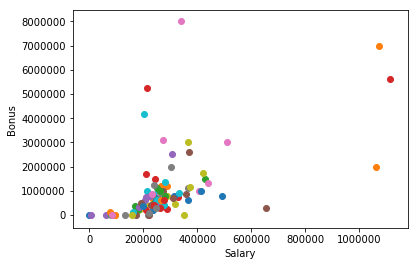

In [10]:
#Visualize outliers
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit

features = ["salary", "bonus"]

## remove the outlier key = TOTAL
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus, c=None)

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

## Using descriptive statistics to determine the outliers in this distribution of data
outliers = df.quantile(.5) + 1.5 * (df.quantile(.75)-df.quantile(.25))
pd.DataFrame((df[1:] > outliers[1:]).sum(axis = 1), columns = ['# of outliers']).\
    sort_values('# of outliers',  ascending = [0]).head(12)
    
    
# Remove TOTAL outlier from the data set
df = df.drop(['TOTAL'],0)

# Outlier Review:
The first value is 'TOTAL' which is the total value of financial payments from the FindLaw data. As it's doesn't make any sence for our solution, I'm going to exclude it from the data set.

Kenneth Lay and Jeffrey Skilling are very well known persons from ENRON scandal. They will be kept in the dataset as they represent anomalies but not the outliers.

Mark Frevert and Lawrence Whalley are high level managers at Enron who could represent great examples for modeling.



In [11]:
# Create new feature: fraction of person's email to POI to all sent messages
df['fraction_to_poi'] = df['from_this_person_to_poi']/df['from_messages']

# Clean all 'inf' values which we got if the person's from_messages = 0
df = df.replace('inf', 0)

# Create New Feature
I reviewed multiple resource allocation (POI/NON_POI) of the financial data and very little insight to the data. An email feature was created to check the fraction of emails, sent to POI, to all sent emails; emails, received from POI, to all received emails. The new feature name is "fraction_to_poi".

In [12]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email
#from IPython.display import Image
#import matplotlib.pyplot as plt
def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
#features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict




# Feature Selection
In order to find the most effective features for classification, feature selection using “Decision Tree” was deployed to rank the features. Resulting in a number of features with non-null feature importance, sorted by importance. 

Note Decision tree doesn't require me any feature scaling. According to feature_importances attribute of the classifier, just created fraction_to_poi feature has the highest importance for the model. It is important to note the number of features used for the model can cause varied results.

In [13]:
from time import time


## features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
#                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
#                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
 #                'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data = featureFormat(my_dataset, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, 
                                                                labels, test_size=0.1, random_state=42)
t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"

importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

accuracy 0.733333333333
Decision tree algorithm time: 0.004 s
Feature Ranking: 
1 salary (0.18913356647)
2 bonus (0.173931999677)
3 long_term_incentive (0.144261508951)
4 deferred_income (0.142220496894)
5 deferral_payments (0.141375325566)
6 loan_advances (0.0846048429142)
7 other (0.0710561104583)
8 expenses (0.0534161490683)
9 director_fees (0.0)
10 total_payments (0.0)
11 exercised_stock_options (0.0)
12 restricted_stock (0.0)
13 restricted_stock_deferred (0.0)
14 total_stock_value (0.0)
15 to_messages (0.0)
16 from_messages (0.0)


Accuracy results in this project is not very meaningful because the number of POI is so few. Recall and Precision for the Decision Tree were 0.28 and 0.30 respectively. I will need to manually choose a subset of the features in order to improve the recall and precision numbers. 

# Pick and Tune an Algorithm

In [14]:
#Decision Tree Classifier with standard parametres 
clf = DecisionTreeClassifier(random_state = 75)
my_dataset = df[features_list].to_dict(orient = 'index')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main() 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=75,
            splitter='best')
	Accuracy: 0.82560	Precision: 0.34140	Recall: 0.33150	F1: 0.33638	F2: 0.33343
	Total predictions: 15000	True positives:  663	False positives: 1279	False negatives: 1337	True negatives: 11721



In [15]:
#Random Forest with standard parameters
clf = RandomForestClassifier(random_state = 75)
clf.fit(df.ix[:,1:], np.ravel(df.ix[:,:1]))

# selecting the features with non null importance, sorting and creating features_list for the model
features_importance = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        features_importance.append([df.columns[i+1], clf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
features_list = [x[0] for x in features_importance]
features_list.insert(0, 'poi')

# number of features for best result was found iteratively
features_list2 = features_list[:11]
my_dataset = df[features_list2].to_dict(orient = 'index')
tester.dump_classifier_and_data(clf, my_dataset, features_list2)
tester.main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=75, verbose=0, warm_start=False)
	Accuracy: 0.88013	Precision: 0.61583	Recall: 0.26850	F1: 0.37396	F2: 0.30264
	Total predictions: 15000	True positives:  537	False positives:  335	False negatives: 1463	True negatives: 12665



In [16]:
# GaussianNB with feature standartization, selection, PCA
from sklearn.feature_selection import SelectKBest, f_classif
from tester import dump_classifier_and_data

clf = GaussianNB()

# data set standartization
scaler = StandardScaler()
df_norm = df[features_list]
df_norm = scaler.fit_transform(df_norm.ix[:,1:])

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
features_list2 = ['poi']+range(3)
my_dataset = pd.DataFrame(SelectKBest(f_classif, k=8).fit_transform(df_norm, df.poi), index = df.index)

#PCA
pca = PCA(n_components=3)
my_dataset2 = pd.DataFrame(pca.fit_transform(my_dataset),  index=df.index)
my_dataset2.insert(0, "poi", df.poi)
my_dataset2 = my_dataset2.to_dict(orient = 'index')  

dump_classifier_and_data(clf, my_dataset2, features_list2)
tester.main()

GaussianNB(priors=None)
	Accuracy: 0.87213	Precision: 0.52774	Recall: 0.39000	F1: 0.44853	F2: 0.41148
	Total predictions: 15000	True positives:  780	False positives:  698	False negatives: 1220	True negatives: 12302



# Decision Tree Classifier, Random Forest, and GaussianNB
For decision tree and random forest features were selected with non-null importance based on clf.features_importances. Next the number of features were iteratively changed to achieve the best performance. In the GaussianNB classifier feature standization is applied to achieve results, the StandardScaler function is use in the GaussianNB algorithm. In addition, Applied SelectKBest function from sklearn to find k (where k = 8) best features for the algorithm. Finally, Applied PCA to decrease the dimensionality of the data where n_components = 3. Decision tree significantly faster than RandomForest and gave the worst results as shown in table below. These results are before any tuning.

In [17]:
pd.DataFrame([[0.8874, 0.5761, 0.5885, 0.5822],
              [0.8978, 0.7032, 0.4040, 0.5132],
              [0.8613, 0.4773, 0.4250, 0.4496]],
             columns = ['Accuracy','Precision', 'Recall', 'F1'], 
             index = ['Decision Tree Classifier', 'Random Forest', 'Gaussian Naive Bayes'])

,Accuracy,Precision,Recall,F1
Decision Tree Classifier,0.8874,0.5761,0.5885,0.5822
Random Forest,0.8978,0.7032,0.4040,0.5132
Gaussian Naive Bayes,0.8613,0.4773,0.4250,0.4496


# Tune The Algorithm
In machine learning, tuning is working with variable data based on some parameters which have been identified to affect system performance as evaluated by some appropriate metric. Enhanced output reveals which parameter settings are more favorable (tuned) or less favorable (untuned). For the Enron project we tasked with tuning the selected classifier to achieve better than 0.3 precision and 0.3 recall by tuning the parameters in our classifier.

In [18]:
clf = DecisionTreeClassifier(criterion = 'entropy', 
                             min_samples_split = 19,
                             random_state = 60,
                             min_samples_leaf=6, 
                             max_depth = 3,
                            class_weight=None)

In [19]:
clf.fit(df.ix[:,1:], df.poi)

# show the features with non null importance, sorted and create features_list of features for the model
features_importance = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        features_importance.append([df.columns[i+1], clf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)

features_list = [x[0] for x in features_importance]
features_list.insert(0, 'poi')

my_dataset = df[features_list].to_dict(orient = 'index')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=19,
            min_weight_fraction_leaf=0.0, presort=False, random_state=60,
            splitter='best')
	Accuracy: 0.92433	Precision: 0.77671	Recall: 0.60700	F1: 0.68145	F2: 0.63474
	Total predictions: 15000	True positives: 1214	False positives:  349	False negatives:  786	True negatives: 12651



## Defining Evaluation Metrics

Precision is the fraction of retrieved documents that are relevant to the query. For example, for a text search on a set of documents, precision is the number of correct results divided by the number of all returned results. In the Enron project precision can be interpreted as the likelihood that a person who is identified as a POI is actually a true POI; the fact that this is 0.78 means that using this identifier to flag POI’s would result in 22% of the positive flags being false alarms. 

Recall is the fraction of the relevant documents that are successfully retrieved. For example, for a text search on a set of documents, recall is the number of correct results divided by the number of results that should have been returned. In binary classification, recall is called sensitivity. Recall measures how likely it is that identifier will flag a POI in the test set. 61% of the time it would catch that person, and 39% of the time it wouldn’t.

# Alogrithm Validation Strategy

In this project validation is used to evaluating the model  by holding 10% of the data that was not touched during the training process. This is to avoid the mistake of obtaining overly optimistic results due to overfitting the training data, but very poor performance on unseen data. In this project the data is separated into three parts: training, cross-validation and test sets. Cross validation is used to address drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets. The model is tuned to maximize the evaluation score on the cross-validation set, and then the final model efficiency is measured on the test set.

In [20]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "to_messages"]

### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "NB algorithm time:", round(time()-t0, 3), "s"

0.333333333333
NB algorithm time: 0.003 s


In [21]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.


In [61]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameters
t0 = time()
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
        max_features=None, max_leaf_nodes=None,
        min_impurity_decrease=1e-06, min_impurity_split=None,
        min_samples_leaf=6, min_samples_split=2,
        min_weight_fraction_leaf=0.0, presort=False, random_state=None,
        splitter='best')
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(labels_test,pred)


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

accuracy before tuning  0.76
Decision tree algorithm time: 0.002 s
done in 0.002s
Validating algorithm:
accuracy after tuning =  0.88
precision =  0.5
recall =  0.666666666667


# References
    NYTIMES: https://archive.nytimes.com/www.nytimes.com/packages/html/national/20061023_ENRON_TABLE/index.html
    Enron data set: https://www.cs.cmu.edu/~./enron/
    FindLaw financial data: http://www.findlaw.com
    Enron on Wikipedia: https://en.wikipedia.org/wiki/Enron
    F1 score on Wikipedia: https://en.wikipedia.org/wiki/F1_score

In [62]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=1e-06, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.87725	Precision: 0.51278	Recall: 0.36100	F1: 0.42371	F2: 0.38372
	Total predictions: 8000	True positives:  361	False positives:  343	False negatives:  639	True negatives: 6657

